# Import Data
- Each row will represent a __single season's statistics__ from a single player.
- Most players will have multiple rows, as most played multiple seasons.

In [1]:
from helper import *

In [2]:
# get passing data
pass_df = load_pass_data()

# get rushing data
rush_df = load_rush_data()

# left join to ensure we keep all QBs with passing data, as this is more important than rushing data
df = pass_df.merge(rush_df, on=['player', 'year'], how='left')

# view duplicate players and unique QBs
df.duplicated().sum(), len(set(df.player))

(0, 289)

- No duplicate players.
- 289 unique NFL quarterbacks.

In [3]:
# view shape and nulls
show_shape_and_nulls(df)

Shape: (1323, 64)
Null values:


,player,team_name,player_game_count,pass_accuracy_percent,pass_aimed_passes,pass_attempts,pass_avg_depth_of_target,pass_avg_time_to_throw,pass_bats,pass_big_time_throws,pass_btt_rate,pass_completion_percent,pass_completions,pass_def_gen_pressures,pass_drop_rate,pass_dropbacks,pass_drops,pass_first_downs,pass_grades_hands_fumble,pass_grades_offense,pass_grades_pass,pass_hit_as_threw,pass_interceptions,pass_passing_snaps,pass_penalties,pass_pressure_to_sack_rate,pass_qb_rating,pass_sack_percent,pass_sacks,pass_scrambles,pass_spikes,pass_thrown_aways,pass_touchdowns,pass_turnover_worthy_plays,pass_twp_rate,pass_yards,pass_ypa,year,rush_attempts,rush_avoided_tackles,rush_breakaway_attempts,rush_breakaway_percent,rush_breakaway_yards,rush_designed_yards,rush_elu_recv_mtf,rush_elu_rush_mtf,rush_elu_yco,rush_elusive_rating,rush_explosive,rush_first_downs,rush_fumbles,rush_gap_attempts,rush_grades_offense_penalty,rush_grades_run,rush_longest,rush_run_plays,rush_scramble_yards,rush_total_touches,rush_touchdowns,rush_yards,rush_yards_after_contact,rush_yco_attempt,rush_ypa,rush_zone_attempts
0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0,0,0,97,97,97,109,97,97,97,97,149,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97


- 1323 QB seasons.
- Very few nulls in the passing columns.
- Around 100 nulls in the rushing columns.
- These values will be imputed with 0.

In [4]:
# fill nulls with 0 and check
df = df.fillna(0)
df.isnull().sum().sum()

0

# Experience
- An "exp" feature will be added to represent the player's __years of experience__. For example, a rookie quarterback would have exp=0.
- 2006 QBs will need to be handeled uniquely, as most are not rookies.
- I manually found the experience of players in the 2006 season. This is found in the [helper file](./helper.py).

In [5]:
# add experience col to df
df['exp'] = np.nan

# add experience for 2006 QBs
df.loc[df['year'] == 2006, 'exp'] = df.loc[df['year'] == 2006, 'player'].map(EXP_2006)

# check
df[['player', 'exp', 'year']].head()

,player,exp,year
0,Brett Favre,15.0,2006
1,Jon Kitna,10.0,2006
2,Marc Bulger,6.0,2006
3,Peyton Manning,8.0,2006
4,Drew Brees,5.0,2006


- QBs who played in 2006 season have an "exp" value, non-2006 QBs have NaN value.

In [6]:
# group by index and fill experience values, drop multi-index
df = df.groupby('player').apply(fill_experience)

# Patrick Mahomes
df.query('player == "Patrick Mahomes"')[['player', 'year', 'exp']]

,player,year,exp
853,Patrick Mahomes,2017,0
875,Patrick Mahomes,2018,1
956,Patrick Mahomes,2019,2
1012,Patrick Mahomes,2020,3
1090,Patrick Mahomes,2021,4
1166,Patrick Mahomes,2022,5
1248,Patrick Mahomes,2023,6


- All players now have a corresponding experience for each of their seasons.

# Target Variable
- For each season __x__, the target is the grades_offense stat of season __x + 1__.

In [7]:
# add target col
df['target'] = df.groupby('player')['pass_grades_offense'].shift(-1)

# Mahomes
df.query('player == "Patrick Mahomes"')[['player', 'year', 'pass_grades_offense', 'target']]

,player,year,pass_grades_offense,target
853,Patrick Mahomes,2017,72.6,93.2
875,Patrick Mahomes,2018,93.2,83.6
956,Patrick Mahomes,2019,83.6,91.4
1012,Patrick Mahomes,2020,91.4,77.1
1090,Patrick Mahomes,2021,77.1,91.3
1166,Patrick Mahomes,2022,91.3,85.1
1248,Patrick Mahomes,2023,85.1,NaN


- Players in their final season will have a NaN value for the target variable (as seen above).
- These rows cannot be used to train model, as we don't have the grades_offense stat of the next year (it doesn't exist).

In [ ]:
# drop rows with null target (players in their final season and most recent season)
df = df.dropna(subset=['target'])
df.isnull().sum().sum() 

0

# Past Performance

In [72]:
def plot_hist_with_annot(df, col, bins=None, xticklabels=None, vertical_lines=None, color='black'):
    """
    Plots a histogram of a column and optionally adds vertical lines with percentage annotations.

    Args:
    - df (pd.DataFrame): DataFrame containing the data.
    - col (str): Column name to plot.
    - bins (int, optional): Number of bins in the histogram. Default is the square root of the number of rows in the DataFrame.
    - vertical_lines (list[int], optional): List of x-values where vertical lines should be drawn. Defaults to None.

    Returns:
    - None
    """

    # default bins (square root of number of rows)
    if bins is None:
        bins = int(np.sqrt(df.shape[0]))

    # get data
    data = df[col]

    # compute histogram
    counts, bin_edges = np.histogram(data, bins=np.arange(data.min(), data.max() + 2) - 0.5)

    # compute bin centers (which are your actual data values)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # plot with bars centered
    fig, ax = plt.subplots(figsize=(18, 9))
    ax.bar(bin_centers, counts, width=1.0, align='center', color=color, edgecolor='black')

    # center X ticks under the bars
    ax.set_xticks(np.arange(data.min(), data.max() + 1))
    ax.set_xticklabels(np.arange(data.min(), data.max() + 1))

    # set x-tick labels
    if xticklabels:
        ax.set_xticks(xticklabels)
        ax.set_xticklabels(xticklabels)

    # add vertical lines and region annotations
    if vertical_lines:
        vertical_lines = sorted(vertical_lines)
        for x in vertical_lines:
            ax.axvline(x=x, color='red', linestyle='dashed', linewidth=2)

        total_count = len(data)
        prev_x = data.min()
        for x in vertical_lines + [data.max()]:
            region_pct = ((data >= prev_x) & (data < x)).sum() / total_count * 100
            ax.text((prev_x + x) / 2, max(counts) * 0.9, f'{region_pct:.1f}%',
                    color='black', fontsize=12, ha='center', va='center',
                    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))
            prev_x = x

    plt.show()

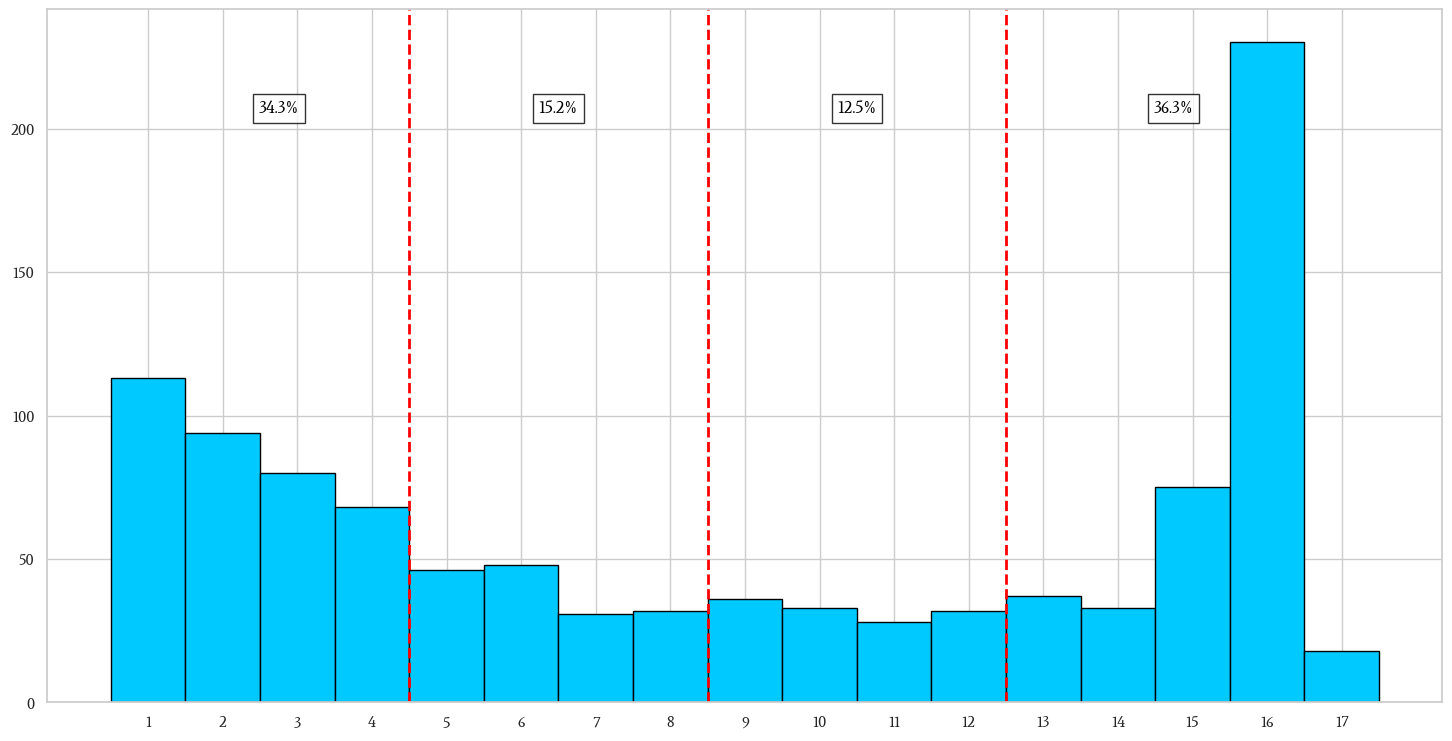

In [73]:
# plot histogram of player_game_count
plot_hist_with_annot(df, 'player_game_count', vertical_lines=[4.5, 8.5, 12.5], color=COLORS[0])

- Only 36% of the rows represent a season where a QB played at least 13 games.
- The other 64% represents seasons in which starting QBs were injured, or just seasons from backup QBs who only play in a few games.

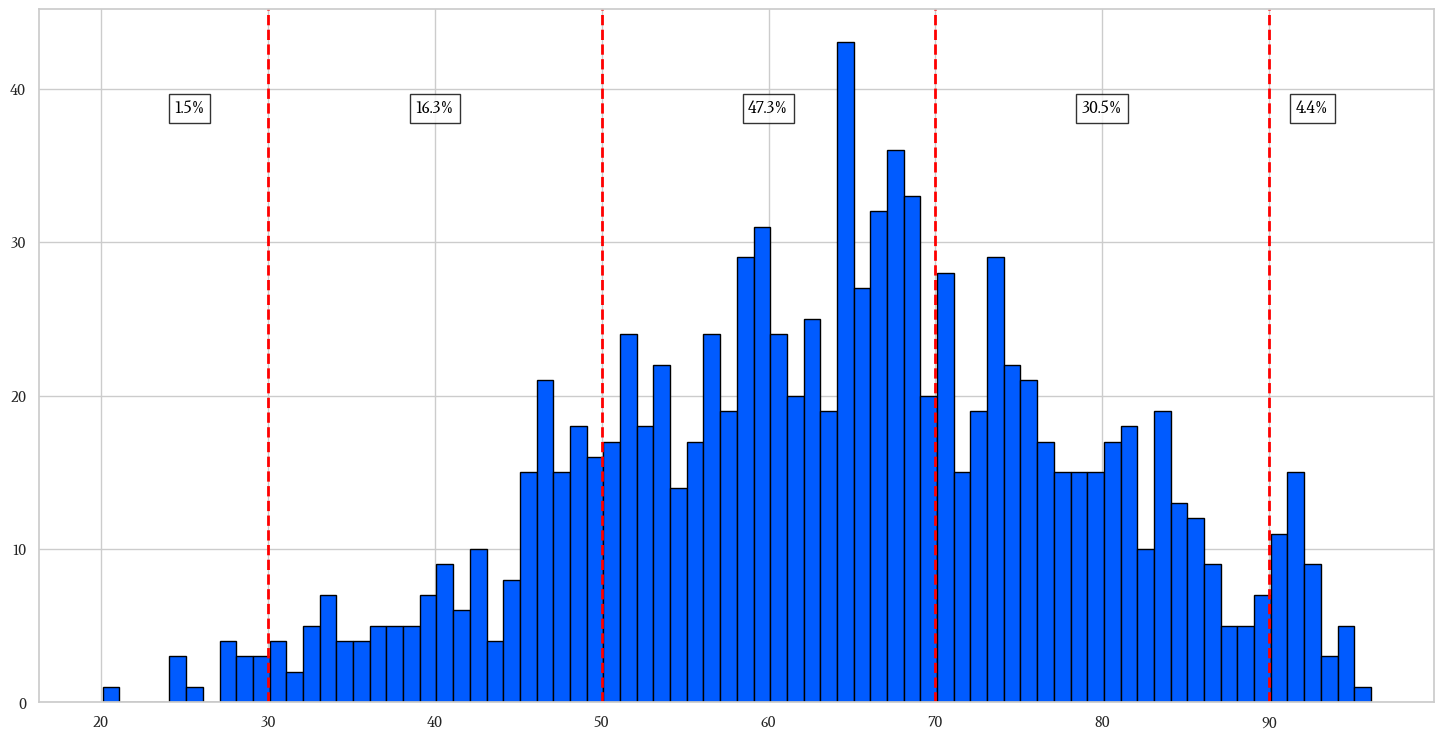

,count,mean,std,min,25%,50%,75%,max
pass_grades_offense,1034.0,64.012186,14.800543,20.6,53.8,64.7,74.375,95.2


In [75]:
# plot histogram of player_game_count
plot_hist_with_annot(df, 'pass_grades_offense', xticklabels=[20 ,30, 40, 50, 60, 70, 80, 90], vertical_lines=[30, 50, 70, 90], color=COLORS[1])

# distribution of offensive grades
df[['pass_grades_offense']].describe().T

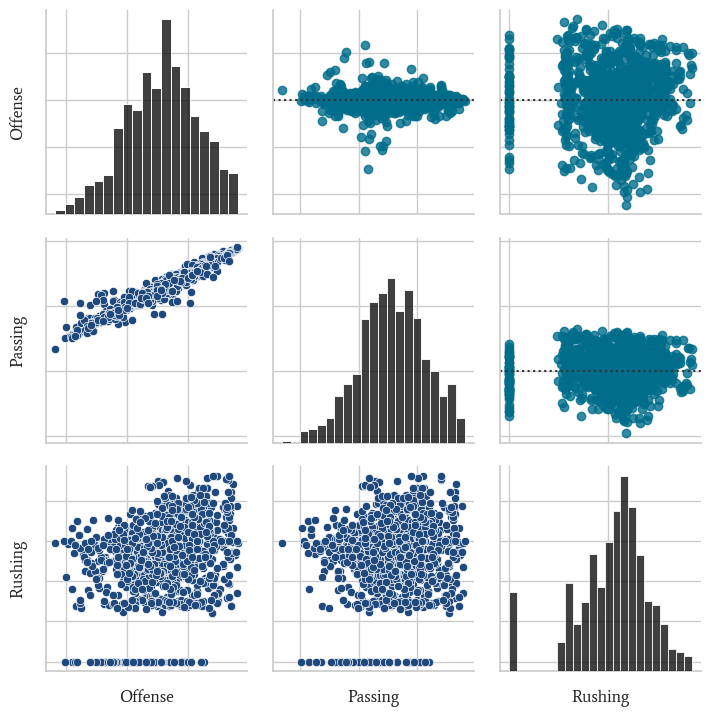

In [25]:
# rename columns for the plot
df_rename = df.rename(columns={'pass_grades_offense': 'Offense', 'pass_grades_pass': 'Passing', 'rush_grades_run': 'Rushing'})

# create pairplot
g = sns.PairGrid(df_rename[['Offense', 'Passing', 'Rushing']])

# map residual plot to upper triangle
g.map_upper(sns.residplot, color=COLORS[2]) 

# map regression plot to the lower triangle
g.map_lower(sns.scatterplot, color=COLORS[3])

# map histogram to the diagonal
g.map_diag(sns.histplot, color=COLORS[4])

# remove tick labels
for ax in g.axes.flat: 
    ax.set_xticklabels([])
    ax.set_yticklabels([]);

In [32]:
# correlation
df[['pass_grades_offense', 'pass_grades_pass', 'rush_grades_run']].corr()#.iloc[[0]]

,pass_grades_offense,pass_grades_pass,rush_grades_run
pass_grades_offense,1.000000,0.966973,0.240137
pass_grades_pass,0.966973,1.000000,0.116990
rush_grades_run,0.240137,0.116990,1.000000


- Passing grade correlates very strongly with a QB's overall offensive grade (0.97 correlation).
- Rush grade has a much smaller correlation with offensive grade at 0.24. Rush grade correlates even less with passing grade with a correlation of only 0.11.
- This makes sense, as the quarterback position is primarily responsible for passing the football. Although rushing QBs have become more standard in today's league, a QB's ability to pass the football effictively and consistently has a much greater impact on their offensive performance than their rushing capabilities.

- I will look at each player's offensive grade over their 3 most recent seasons, and use the mean (capturing peformance) along with the standard deviation (capturing consistency).

In [ ]:
# ensure values are sorted properly
df = df.sort_values(by=['player', 'exp']).reset_index(drop=True)



,player,year,exp
0,A.J. Feeley,2006,5
1,A.J. Feeley,2007,6
2,A.J. Feeley,2011,7
3,A.J. McCarron,2015,0
4,A.J. McCarron,2017,1


In [ ]:
# use current season's offensive grade + 2 previous seasons
window_size = 3

# calculate rolling mean and std
# 'min_periods=1' ensures we calculate statistics even if there's only one past season. drop multi-index with droplevel()
df['rolling_mean'] = df.groupby('player')['pass_grades_offense'].apply(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()).droplevel(0)
df['rolling_std'] = df.groupby('player')['pass_grades_offense'].apply(
    lambda x: x.rolling(window=window_size, min_periods=1).std()).droplevel(0)

# fill nulls
df = df.fillna(0)

In [ ]:
# export data
df.to_csv('./data/clean/features.csv')